# Article Recommender for IBM Watson Users

Note: This workspace is based on a project on the Udacity Data Science Nanodegree 



In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle

%matplotlib inline

df_user_item = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df_user_item['Unnamed: 0'] #Remove redundant column
del df_content['Unnamed: 0'] #Remove Redundant column

In [20]:
print(df_user_item.shape)
df_user_item.head(10)

(45993, 3)


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2
5,1432.0,visualize data with the matplotlib library,b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5
6,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
7,593.0,upload files to ibm data science experience us...,3bbca9c41c66c4ecc46bc14eac7b7ab1ab0a5bea
8,1314.0,healthcare python streaming application demo,8b6fb4bbb7a27b336ba35420bf58337d877455c7
9,1185.0,classify tumors with machine learning,35d5799b6ea3ba24f921ed38f7f9a8039ad06ba4


In [11]:
print(df_content.shape)
df_content.head()

(1056, 5)


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


## Exploratory Data Analysis

First look at the user-item interaction dataset:

In [53]:

print("Length of user-item interaction dataset:", df_user_item.shape[0] )
df_user_item['article_id'].is_unique
#investigate duplicates
print("Number of duplicates is:", df_user_item['article_id'].duplicated().sum())
print("So it seems that this is a table of accesses to articles; hence the repetition of the article IDs")

#It truns out that the articles community file only contains details of article IDs 0 to 1050
print ("\nNumber of Interactions related to an article contained in the article community file:", (df_user_item['article_id'] <= 1050).sum())

Length of user-item interaction dataset: 45993
Number of duplicates is: 45279
So it seems that this is a table of accesses to articles; hence the repetition of the article IDs

Number of Interactions related to an article contained in the article community file: 21454


Let's get a feel of how often and the distribution of how many articles a user interacts with in the dataset:

In [81]:
unique_for_each_user = df_user_item[['email','article_id']].groupby(['email']).nunique()

In [82]:
striped_unique_for_each_user = samples['article_id'].values

Text(0.5, 1.0, 'Focus on 0 to 20 region of above distribution')

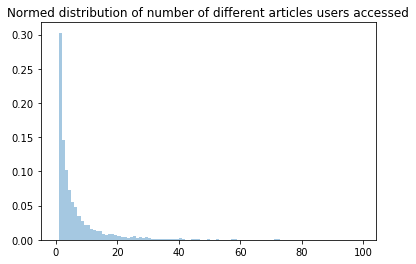

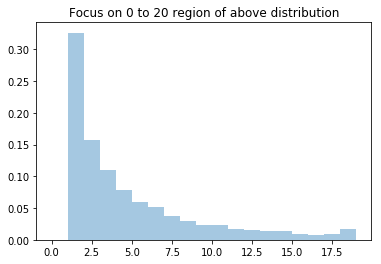

In [88]:
ax = sns.distplot(striped_unique_for_each_user, bins=np.arange(0,100), kde=False, norm_hist=True )
ax.set_title("Normed distribution of number of different articles users accessed")
plt.figure()
ax2 = sns.distplot(striped_unique_for_each_user, bins=np.arange(0,20), kde=False, norm_hist=True )
ax2.set_title("Focus on 0 to 20 region of above distribution")


In [180]:
median_value = np.median(striped_unique_for_each_user)
print("50%% of individuals interact with %i number of articles or fewer" % int(median_value))

50% of individuals interact with 3 number of articles or fewer


In [195]:
max_value = np.max(df_user_item['email'].value_counts())
print("The maximum number of user-article interactions by any 1 user is:", max_value)

The maximum number of user-article interactions by any 1 user is: 364


Explore and remove duplicate articles from the df_content dataframe:

In [96]:
duplicate_subset = df_content[df_content['article_id'].duplicated()]

In [97]:
print(duplicate_subset)

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [123]:
df_content = df_content.drop(list(duplicate_subset.index),axis=0)
print("New length of df_content:", df_content.shape[0])

New length of df_content: 1051


In [197]:
n_uniq_interaction = df_user_item['article_id'].nunique(dropna=True)
print("Number of unique articles that have an interaction with a user:", n_uniq_interaction )

Number of unique articles that have an interaction with a user: 714


In [ ]:
df_user_item['article_id'].unique()

In [199]:
#The total number of unique articles on the IBM platform

unique_articles = df_content['article_id'].unique()

print("Number of unique articles in the dataset (whether they have any interactions or not):", len(unique_articles) )

Number of unique articles in the dataset (whether they have any interactions or not): 1051


In [150]:
#Users are identified by email
unique_users = df_user_item['email'].nunique(dropna=True)
print("Number of unique users in the dataset. (excluding null values):", unique_users )

Number of unique users in the dataset. (excluding null values): 5148


In [152]:
print("Number of user-article interactions in the dataset:", df_user_item.shape[0] )

Number of user-article interactions in the dataset: 45993


In [171]:
most_pop_article =df_user_item['article_id'].value_counts().index[0]
max_counts = df_user_item['article_id'].value_counts().values[0]

print("Most viewed article_id:", int(most_pop_article) )
print("How often it was viewed:", max_counts)

Most viewed article_id: 1429
How often it was viewed: 937


## Rank-Based Recommendations

First, Let's implement a very simple rank-based recommender

We don't really have much to go on here for ranking the articles except for the number of times the article was accessed. Our ranks will, therefore, be based on that.


In [208]:
def get_top_articles(n, df=df):
    """
    Returns a list of the top articles in a user-item interaction dataframe

    Args:
        n - (int) the number of top articles to return
        df - (pandas dataframe) df of user-item interactions as defined at the top of the notebook 
    
    Returns:
        top_articles - (list) A list of the top 'n' article titles 
    """
    
    top_articles = df['title'].value_counts(dropna=True).index[:n]
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    """
    Returns a list of indexes of the top articles in a user-item interaction dataframe

    Args:
        n - (int) the number of top articles to return
        df - (pandas dataframe) df as defined at the top of the notebook 
    
    Returns:
        top_articles - (list) A list of the top 'n' article id's
    """
     
    top_articles = df['title'].value_counts(dropna=True).values[:n]    
        
    return top_articles # Return the top article ids

The **top ten** articles according to our rank-based recommender are:

In [206]:
print(get_top_articles(10))

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object')


..And they correspond to the following article ids:

In [207]:
print(get_top_article_ids(10))

[937 927 671 643 627 614 572 565 512 483]


## User-User Based Collaborative Filtering

`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [231]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    """
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise

    Args:
        df - pandas dataframe with article_id, title, user_id columns
    
    Returns:
        user_item - user item matrix 
    """
    df_local = df[['email', 'article_id']]
    df_local['value'] = 1
    user_item = df_local.pivot_table(index='email', columns='article_id', values='value', fill_value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)